# <center><h1>Project Shift, Don't Lift</center></h1> 

***
###### <center><h1>An investigation into position prediction in Formula 1</center></h1> 
***

<center><h1>Part II: MODELING</center></h1> 

## Feature Engineering
Now that the final data set has been created & explored, it's time to create a few models. Feature engineering will first need to take place to transform all object type data into numeric data, as well as to binarize the target variable to predict finishing in the top 5 positions or not.

Given this is a classification problem (will the driver finish in the top 5 or not?), a LogisticRegression model will be first model of choice.

- Will start by importing the necessary tools.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns=None
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import warnings 
warnings.filterwarnings("ignore")

- Next, read in the recently created csv for the final dataframe.

In [2]:
f1_df = pd.read_csv('data/f1_df.csv')
f1_df.head()

,grid,finishing_position,completed_laps,status,driverRef,dob,nationality,round,date,circuit_lat,circuit_lng,constructor,constructor_nationality
0,1,1,58,Finished,hamilton,1985-01-07,British,1,2008-03-16,-37.8497,144.968,McLaren,British
1,3,5,58,Finished,kovalainen,1981-10-19,Finnish,1,2008-03-16,-37.8497,144.968,McLaren,British
2,4,3,58,Finished,hamilton,1985-01-07,British,1,2007-03-18,-37.8497,144.968,McLaren,British
3,2,2,58,Finished,alonso,1981-07-29,Spanish,1,2007-03-18,-37.8497,144.968,McLaren,British
4,11,6,58,Finished,hamilton,1985-01-07,British,2,2010-03-28,-37.8497,144.968,McLaren,British


In [3]:
print(f'Shape: {f1_df.shape}')
print(f'# of Nulls: {f1_df.isna().sum().sum()}')
print(f'# of Duplicates: {f1_df.duplicated().sum()}')

Shape: (25140, 13)
# of Nulls: 0
# of Duplicates: 0


- Everything looks good so far, now onto features.

In [4]:
f1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25140 entries, 0 to 25139
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   grid                     25140 non-null  int64  
 1   finishing_position       25140 non-null  int64  
 2   completed_laps           25140 non-null  int64  
 3   status                   25140 non-null  object 
 4   driverRef                25140 non-null  object 
 5   dob                      25140 non-null  object 
 6   nationality              25140 non-null  object 
 7   round                    25140 non-null  int64  
 8   date                     25140 non-null  object 
 9   circuit_lat              25140 non-null  float64
 10  circuit_lng              25140 non-null  float64
 11  constructor              25140 non-null  object 
 12  constructor_nationality  25140 non-null  object 
dtypes: float64(2), int64(4), object(7)
memory usage: 2.5+ MB


- Will begin feature engineering for all features that won't be onehotencoded. Reasoning behind this is OHE will make the dataframe several columns wide and column correlation is needed to be checked prior to modeling. 

### `grid`
Drivers starting with grid position of '0' are actually starting at the end of the grid. This is going to effect predicting power & correlation as of 6% of the values are seen and are numerically misrepresented in order of grid position. One solution is to find the average grid count for these races in which contained a "0" grid position, and substitute the numbers. This analysis was executed in the **Results - Grid** tableau workbook, where it appears the average grid count is 27.64, therefore will encode all '0' grid positions as '27.64'.
- Note this isn't a perfect solution, however is should provide greater modeling accuracy results compared to not changing at all.

In [5]:
a = f1_df['grid']
f1_df['grid'] = np.where((f1_df['grid'] == 0), 27.64, a)
f1_df['grid'].value_counts()

27.64    1589
7.00     1055
1.00     1055
11.00    1051
5.00     1051
9.00     1051
4.00     1051
10.00    1050
3.00     1049
8.00     1049
12.00    1046
13.00    1045
2.00     1045
6.00     1044
14.00    1040
15.00    1033
16.00    1019
17.00    1008
18.00     971
19.00     958
20.00     927
21.00     697
22.00     656
23.00     453
24.00     429
25.00     301
26.00     248
27.00      46
28.00      30
29.00      25
30.00      19
31.00      18
32.00      17
33.00      13
34.00       1
Name: grid, dtype: int64

### `date`
Time to extract the day, month, and year information in `date` column to separate columns. Will need to change dtype first.

In [6]:
# cast 'date' column objects as dates
f1_df['date'] = f1_df['date'].astype('datetime64')

# extract day, month, & year to new columns
f1_df['race_day'] = f1_df['date'].dt.day
f1_df['race_month'] = f1_df['date'].dt.month
f1_df['race_year'] = f1_df['date'].dt.year

# drop duplicated date column
f1_df = f1_df.drop(['date'], axis=1)

# check results
f1_df.head()

,grid,finishing_position,completed_laps,status,driverRef,dob,nationality,round,circuit_lat,circuit_lng,constructor,constructor_nationality,race_day,race_month,race_year
0,1.0,1,58,Finished,hamilton,1985-01-07,British,1,-37.8497,144.968,McLaren,British,16,3,2008
1,3.0,5,58,Finished,kovalainen,1981-10-19,Finnish,1,-37.8497,144.968,McLaren,British,16,3,2008
2,4.0,3,58,Finished,hamilton,1985-01-07,British,1,-37.8497,144.968,McLaren,British,18,3,2007
3,2.0,2,58,Finished,alonso,1981-07-29,Spanish,1,-37.8497,144.968,McLaren,British,18,3,2007
4,11.0,6,58,Finished,hamilton,1985-01-07,British,2,-37.8497,144.968,McLaren,British,28,3,2010


### `dob`
Time to extract the day, month, and year information in driver's `dob` column to separate columns. Will need to change dtype first.

In [7]:
# cast 'dob' column objects as dates
f1_df['dob'] = f1_df['dob'].astype('datetime64')

# extract day, month, & year to new columns
f1_df['dob_day'] = f1_df['dob'].dt.day
f1_df['dob_month'] = f1_df['dob'].dt.month
f1_df['dob_year'] = f1_df['dob'].dt.year

# drop duplicated date column
f1_df = f1_df.drop(['dob'], axis=1)

# check results
f1_df.head()

,grid,finishing_position,completed_laps,status,driverRef,nationality,round,circuit_lat,circuit_lng,constructor,constructor_nationality,race_day,race_month,race_year,dob_day,dob_month,dob_year
0,1.0,1,58,Finished,hamilton,British,1,-37.8497,144.968,McLaren,British,16,3,2008,7,1,1985
1,3.0,5,58,Finished,kovalainen,Finnish,1,-37.8497,144.968,McLaren,British,16,3,2008,19,10,1981
2,4.0,3,58,Finished,hamilton,British,1,-37.8497,144.968,McLaren,British,18,3,2007,7,1,1985
3,2.0,2,58,Finished,alonso,Spanish,1,-37.8497,144.968,McLaren,British,18,3,2007,29,7,1981
4,11.0,6,58,Finished,hamilton,British,2,-37.8497,144.968,McLaren,British,28,3,2010,7,1,1985


### `finishing_position`
The **Target Variable**; will encode the top 5 finishing positions as "1", the rest as "0".

In [8]:
a = f1_df['finishing_position']
rank1 =  np.where(a <= 5, 1, 0) # take top 5, encode as '1', all remaining positions encoded as '0'.
f1_df['encoded_finish'] = rank1
f1_df.head(25)

,grid,finishing_position,completed_laps,status,driverRef,nationality,round,circuit_lat,circuit_lng,constructor,constructor_nationality,race_day,race_month,race_year,dob_day,dob_month,dob_year,encoded_finish
0,1.0,1,58,Finished,hamilton,British,1,-37.8497,144.968,McLaren,British,16,3,2008,7,1,1985,1
1,3.0,5,58,Finished,kovalainen,Finnish,1,-37.8497,144.968,McLaren,British,16,3,2008,19,10,1981,1
2,4.0,3,58,Finished,hamilton,British,1,-37.8497,144.968,McLaren,British,18,3,2007,7,1,1985,1
3,2.0,2,58,Finished,alonso,Spanish,1,-37.8497,144.968,McLaren,British,18,3,2007,29,7,1981,1
4,11.0,6,58,Finished,hamilton,British,2,-37.8497,144.968,McLaren,British,28,3,2010,7,1,1985,0
5,4.0,1,58,Finished,button,British,2,-37.8497,144.968,McLaren,British,28,3,2010,19,1,1980,1
6,2.0,2,58,Finished,hamilton,British,1,-37.8497,144.968,McLaren,British,27,3,2011,7,1,1985,1
7,4.0,6,58,Finished,button,British,1,-37.8497,144.968,McLaren,British,27,3,2011,19,1,1980,0
8,1.0,3,58,Finished,hamilton,British,1,-37.8497,144.968,McLaren,British,18,3,2012,7,1,1985,1
9,2.0,1,58,Finished,button,British,1,-37.8497,144.968,McLaren,British,18,3,2012,19,1,1980,1


In [9]:
f1_df['encoded_finish'].dtype

dtype('int32')

- Not sure why it converted to 'int32', however to keep things consistent will convert to 'int62'.

In [10]:
f1_df['encoded_finish'] = f1_df['encoded_finish'].astype('int64')
f1_df['encoded_finish'].dtype

dtype('int64')

### `status`
As previously mentioned, converting the `status` column into a binary column is essential in correctly identifying if a driver simply finished the race or not. Statuses that are coded as 'finished' or '+ n_laps' will be encoded as 1 ('finished') and all other statuses will be encoded as 0 ('not finished') by utilizing the **.where()** function.
- **+ n_laps** means the the driver finished the race, however they were n laps behind the racer winner's finishing lap when they cross the checker flag.

In [11]:
f1_df['status'].sort_values(ascending=True).unique()

array(['+1 Lap', '+10 Laps', '+11 Laps', '+12 Laps', '+13 Laps',
       '+14 Laps', '+15 Laps', '+16 Laps', '+17 Laps', '+18 Laps',
       '+19 Laps', '+2 Laps', '+20 Laps', '+21 Laps', '+22 Laps',
       '+23 Laps', '+24 Laps', '+25 Laps', '+26 Laps', '+29 Laps',
       '+3 Laps', '+30 Laps', '+4 Laps', '+42 Laps', '+44 Laps',
       '+46 Laps', '+5 Laps', '+6 Laps', '+7 Laps', '+8 Laps', '+9 Laps',
       '107% Rule', 'Accident', 'Alternator', 'Axle', 'Battery',
       'Brake duct', 'Brakes', 'Broken wing', 'CV joint', 'Chassis',
       'Clutch', 'Collision', 'Collision damage', 'Crankshaft', 'Damage',
       'Debris', 'Did not prequalify', 'Did not qualify', 'Differential',
       'Disqualified', 'Distributor', 'Driver Seat', 'Driver unwell',
       'Driveshaft', 'Drivetrain', 'ERS', 'Electrical', 'Electronics',
       'Engine', 'Engine fire', 'Engine misfire', 'Excluded', 'Exhaust',
       'Eye injury', 'Fatal accident', 'Finished', 'Fire', 'Front wing',
       'Fuel', 'Fuel leak',

In [12]:
f1_df['status'] = np.where(
    (f1_df['status'] == 'Finished')| 
    (f1_df['status'] == '+1 Lap')|
    (f1_df['status'] == '+2 Laps')|
    (f1_df['status'] == '+3 Laps')|
    (f1_df['status'] == '+4 Laps')|
    (f1_df['status'] == '+5 Laps')|
    (f1_df['status'] == '+6 Laps')|
    (f1_df['status'] == '+7 Laps')|
    (f1_df['status'] == '+8 Laps')|
    (f1_df['status'] == '+9 Laps')|
    (f1_df['status'] == '+10 Laps')|
    (f1_df['status'] == '+11 Laps')|
    (f1_df['status'] == '+12 Laps')|
    (f1_df['status'] == '+13 Laps')|
    (f1_df['status'] == '+14 Laps')|
    (f1_df['status'] == '+15 Laps')|
    (f1_df['status'] == '+16 Laps')|
    (f1_df['status'] == '+17 Laps')|
    (f1_df['status'] == '+18 Laps')|
    (f1_df['status'] == '+19 Laps')|
    (f1_df['status'] == '+20 Laps')|
    (f1_df['status'] == '+21 Laps')|
    (f1_df['status'] == '+22 Laps')|
    (f1_df['status'] == '+23 Laps')|
    (f1_df['status'] == '+24 Laps')|
    (f1_df['status'] == '+25 Laps')|
    (f1_df['status'] == '+26 Laps')|
    (f1_df['status'] == '+29 Laps')|
    (f1_df['status'] == '+30 Laps')|
    (f1_df['status'] == '+42 Laps')|
    (f1_df['status'] == '+44 Laps')|
    (f1_df['status'] == '+46 Laps'), 1, 0)

f1_df['status'].value_counts()

1    13776
0    11364
Name: status, dtype: int64

In [13]:
f1_df.head()

,grid,finishing_position,completed_laps,status,driverRef,nationality,round,circuit_lat,circuit_lng,constructor,constructor_nationality,race_day,race_month,race_year,dob_day,dob_month,dob_year,encoded_finish
0,1.0,1,58,1,hamilton,British,1,-37.8497,144.968,McLaren,British,16,3,2008,7,1,1985,1
1,3.0,5,58,1,kovalainen,Finnish,1,-37.8497,144.968,McLaren,British,16,3,2008,19,10,1981,1
2,4.0,3,58,1,hamilton,British,1,-37.8497,144.968,McLaren,British,18,3,2007,7,1,1985,1
3,2.0,2,58,1,alonso,Spanish,1,-37.8497,144.968,McLaren,British,18,3,2007,29,7,1981,1
4,11.0,6,58,1,hamilton,British,2,-37.8497,144.968,McLaren,British,28,3,2010,7,1,1985,0


### New Feature - `age_at_race`
This is the new feature analyzed from part I that will be now added into the dataframe.

In [14]:
f1_df['age_at_race'] = f1_df['race_year'] - f1_df['dob_year']
f1_df.head()

,grid,finishing_position,completed_laps,status,driverRef,nationality,round,circuit_lat,circuit_lng,constructor,constructor_nationality,race_day,race_month,race_year,dob_day,dob_month,dob_year,encoded_finish,age_at_race
0,1.0,1,58,1,hamilton,British,1,-37.8497,144.968,McLaren,British,16,3,2008,7,1,1985,1,23
1,3.0,5,58,1,kovalainen,Finnish,1,-37.8497,144.968,McLaren,British,16,3,2008,19,10,1981,1,27
2,4.0,3,58,1,hamilton,British,1,-37.8497,144.968,McLaren,British,18,3,2007,7,1,1985,1,22
3,2.0,2,58,1,alonso,Spanish,1,-37.8497,144.968,McLaren,British,18,3,2007,29,7,1981,1,26
4,11.0,6,58,1,hamilton,British,2,-37.8497,144.968,McLaren,British,28,3,2010,7,1,1985,0,25


- This is looking great, however as mentioned before **onehotencoding** is carried out for the remaining categorical features (will make data frame contain several columns), will visit column correlations to see which columns are statically significant.

### Exploring correlations
- A key part of the regression modeling process is to explore correlations (not only between the dependent(target) and independent(predictor) variables, but also between each independent(predictor) variables). 
- A correlation gives us an understanding of how variables vary with respect to another. Investigating the correlations helps determine which features are likely to have the greatest impact on the dependent variable.
- Will utilize the Backward Variable Selection process that starts with all the variables, and then removes the least useful variables, one-at-a-time. 

In [15]:
from scipy.stats import pearsonr

def pearson_df(dataframe, target, alpha=0.05):
    '''
    This function takes a dataframe with a column of interest (target), a significance threshold (alpha) as inputs. It then calculates the correlation coefficients
    and p-values using scipy.stats.pearsonr(), and returns a dataframe of the results
    
    Parameters:
    -----------
    dataframe: a pandas dataframe containing the data to compare
    target: a string specifying one of the columns in the dataframe to compare to the rest of the data
    alpha: a significance threshold for evaluating p-values (default 0.05)
    
    Returns:
    --------
    output: a dataframe containing correlation coefficients and p-values for each variable in dataframe w.r.t. the target variable
    
    '''
    
    # Validate the inputs
    assert isinstance(dataframe, pd.DataFrame), 'dataframe must be a pandas DataFrame'
    assert isinstance(target, str), 'target must be a string'
    assert isinstance(alpha, float), 'alpha must be a float'
    assert(0 <= alpha <= 1), 'alpha must be between 0 and 1'
    
    # Instantiating empty lists
    variable_names = []
    corr_list = []
    p_value_list = []
    
    # Looping across all of the columns in the dataframe
    for column in range(dataframe.shape[1]):
        
        # Calculating the coefficient and p-value for each column w.r.t. the target variable
        corr, p_value = pearsonr(dataframe.iloc[:, column], dataframe[target])
        
        # Add the column name, coefficient, and p-value to their respective lists
        variable_names.append(dataframe.columns[column])
        corr_list.append(corr)
        p_value_list.append(p_value)

    # Turn the three lists into a dataframe for easier viewing
    output = pd.DataFrame(index=variable_names, data={'coefficient': corr_list, 'p-value': p_value_list})
    
    # Add a column which states whether the correlation is significant
    output[f'p-value <= {alpha}'] = np.where(output['p-value'] <= alpha, True, False)
    
    # Drop the target variable from the dataframe
    output = output.drop(target)
    
    print(f'Correlations between data columns and {target}:')
    
    return output

In [16]:
f1_df.drop(columns=['finishing_position'], inplace=True) # drop the 'finishing_position' now that it's been encoded to 'encoded_finish'
nf1_df = f1_df.select_dtypes(["int64", "float64"]) # get all numeric columns
correlation_df = pearson_df(nf1_df, 'encoded_finish') # run function for column correlations against encoded_finish. 
correlation_df

Correlations between data columns and encoded_finish:


,coefficient,p-value,p-value <= 0.05
grid,-0.475657,0.000000e+00,True
completed_laps,0.329456,0.000000e+00,True
round,-0.001352,8.303161e-01,False
circuit_lat,-0.006159,3.287958e-01,False
circuit_lng,0.012871,4.127515e-02,True
race_day,-0.002021,7.486876e-01,False
race_month,-0.000902,8.863147e-01,False
race_year,0.019924,1.581986e-03,True
dob_day,0.001521,8.094399e-01,False
dob_month,-0.022789,3.020016e-04,True


- The correlation coefficients between `round`, `circuit_lat`, `race_day`, `race_month`, `dob_day`, `dob_year` and the target variable `encoded_position` are not statistically significant (p-value > 0.05), therefore should be dropped.
- Through trial an error however, it's discovered that dropping `dob_day` creates that data to have duplicates given so much unique information is stripped away. Given its low p-value, will decide to keep for modeling for the sake of not creating to many duplicate rows.
- Before doing so however, the strength of these correlations can be visualized below:

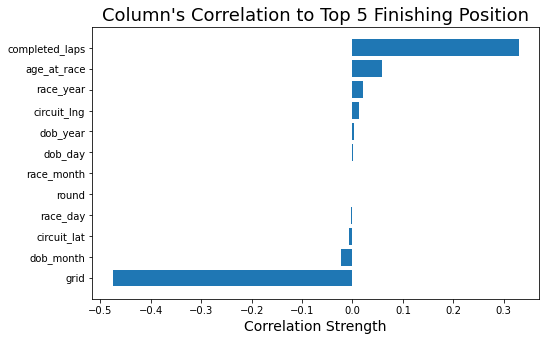

In [17]:
plt.figure(figsize=(8,5))
correlation_df.sort_values(by='coefficient', inplace=True)
plt.barh(correlation_df.index, correlation_df['coefficient'])
plt.title("Column's Correlation to Top 5 Finishing Position", fontsize=18)
plt.xlabel("Correlation Strength", fontsize=14)
plt.show()

Correlation falls on a range of [-1,1],

-1 indicates a perfect negative correlation relationship.
0 indicates no correlation relationship.
and 1 indicates a perfect positive correlation relationship.

**Observations:**

- `completed_lap`: highest positive correlation, makes sense as more laps completed the greater probability finishing in the Top 5 position, or in this case value of 1.
- `age_at_race`: positive correlation, interesting! The older the driver is, the greater probability finishing in the Top 5 position, or in this case value of 1. This makes sense though given the difficulty to podium in F1 - drivers on the top teams usually already have a few years of experience in F1.
- `grid`: largest negative correlation, this makes sense as the lower the grid position a driver starts the race, the greater probability finishing in the Top 5 position, or in this case value of 1.

Time to check correlation between the the independent variables to ensure no multicollinearity. 

In [18]:
# Separate the data into X and y variables
X = nf1_df.drop(columns=['encoded_finish', 'round', 'circuit_lat', 'race_day', 'race_month', 'dob_year'], inplace=False) # X is the data containing the independent variables.
y = nf1_df['encoded_finish'] # y is the target. The dependent variable.

In [19]:
df_corr = X.corr()
df_corr

,grid,completed_laps,circuit_lng,race_year,dob_day,dob_month,age_at_race
grid,1.000000,-0.265752,-0.050097,-0.096856,-0.024730,0.042478,-0.050739
completed_laps,-0.265752,1.000000,-0.096916,0.042140,-0.006921,-0.021058,0.022534
circuit_lng,-0.050097,-0.096916,1.000000,0.296651,0.023605,-0.014726,-0.092330
race_year,-0.096856,0.042140,0.296651,1.000000,0.058066,-0.039089,-0.347914
dob_day,-0.024730,-0.006921,0.023605,0.058066,1.000000,-0.031324,-0.056599
dob_month,0.042478,-0.021058,-0.014726,-0.039089,-0.031324,1.000000,0.121532
age_at_race,-0.050739,0.022534,-0.092330,-0.347914,-0.056599,0.121532,1.000000


- Again, large correlation matrix tables are difficult to absorb, therefore the correlation is better visualized using a heatmap as seen below

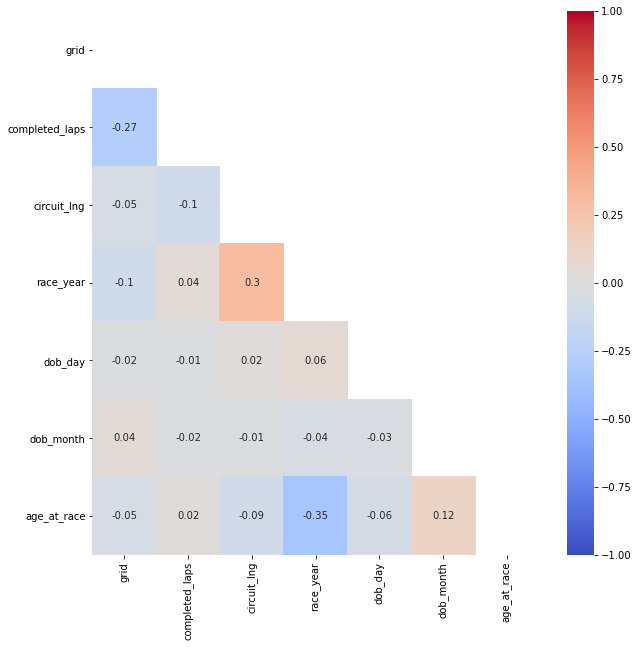

In [20]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_corr.round(2), annot=True, vmin=-1, vmax=1, cmap="coolwarm", mask=np.triu(df_corr))
plt.show()

- In the current predictors, there are no strong correlations however there still is a chance for multicollinearity when using a combination of two or more columns to describe another predictor. 
- To check for multicollinearity, the variance inflation factor can be utilized as it it quantifies the severity of multicollinearity in an ordinary least squares regression analysis as seen below. VIF above 10 is typically considered high, however a cutoff of 5 is also commonly used.

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

grid               4.170334
completed_laps     3.633083
circuit_lng        1.039742
race_year         46.590079
dob_day            4.386051
dob_month          4.173465
age_at_race       33.228106
dtype: float64

- As seen in the above VIF table, the majority columns have a low magnitude of multicollinearity, but `race_year` and `age_at_race` have high magnitudes of multicollinearity. Will drop `race_year` given it's lower correlation strength.

In [22]:
X.drop(columns=['race_year'], inplace=True)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

grid               3.636837
completed_laps     3.287336
circuit_lng        1.016022
dob_day            3.922783
dob_month          4.076543
age_at_race       10.662345
dtype: float64

- This is looking good. `age_at_race` is still slightly high but needed to maintain amount of duplicates. Will drop all specified columns on the **nf1_df** dataframe for easier final concatenation.

In [23]:
nf1_df.drop(columns=['round', 'circuit_lat', 'race_day', 'race_month', 'dob_year', 'race_year'], inplace=True)
nf1_df.head()

,grid,completed_laps,circuit_lng,dob_day,dob_month,encoded_finish,age_at_race
0,1.0,58,144.968,7,1,1,23
1,3.0,58,144.968,19,10,1,27
2,4.0,58,144.968,7,1,1,22
3,2.0,58,144.968,29,7,1,26
4,11.0,58,144.968,7,1,0,25


- Look good, now onto OHE!

### `nationality`

In [24]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the Reviewer_Nationality column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
d_nationality = pd.DataFrame(f1_df['nationality'])
encoded = ohe.fit_transform(d_nationality)
encoded

<25140x41 sparse matrix of type '<class 'numpy.float64'>'
	with 25140 stored elements in Compressed Sparse Row format>

In [25]:
# Convert from sparse matrix to a dense array
dense_array = encoded.toarray()
dense_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

To get the corresponding column names for this one-hot-encoded array, the `.categories_` is accessed which is an attribute of the fitted `OneHotEncoder`:

In [26]:
ohe.categories_

[array(['American', 'American-Italian', 'Argentine', 'Argentine-Italian',
        'Australian', 'Austrian', 'Belgian', 'Brazilian', 'British',
        'Canadian', 'Chilean', 'Colombian', 'Czech', 'Danish', 'Dutch',
        'East German', 'Finnish', 'French', 'German', 'Hungarian',
        'Indian', 'Indonesian', 'Irish', 'Italian', 'Japanese',
        'Liechtensteiner', 'Malaysian', 'Mexican', 'Monegasque',
        'New Zealander', 'Polish', 'Portuguese', 'Rhodesian', 'Russian',
        'South African', 'Spanish', 'Swedish', 'Swiss', 'Thai',
        'Uruguayan', 'Venezuelan'], dtype=object)]

- As seen, the columns are in ascending alphabetical order. These can finally be combined in a dataframe and joined back to the original column to check the result:

In [27]:
# Put into a dataframe to get column names
driver_nat_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)

# Show
driver_nat_df.head()

,American,American-Italian,Argentine,Argentine-Italian,Australian,Austrian,Belgian,Brazilian,British,Canadian,Chilean,Colombian,Czech,Danish,Dutch,East German,Finnish,French,German,Hungarian,Indian,Indonesian,Irish,Italian,Japanese,Liechtensteiner,Malaysian,Mexican,Monegasque,New Zealander,Polish,Portuguese,Rhodesian,Russian,South African,Spanish,Swedish,Swiss,Thai,Uruguayan,Venezuelan
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
driver_nat_df.shape

(25140, 41)

### `driverRef`

In [29]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the Reviewer_Nationality column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
d_ref = pd.DataFrame(f1_df['driverRef'])
encoded = ohe.fit_transform(d_ref)
encoded

<25140x853 sparse matrix of type '<class 'numpy.float64'>'
	with 25140 stored elements in Compressed Sparse Row format>

In [30]:
# Convert from sparse matrix to a dense array
dense_array = encoded.toarray()
dense_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

To get the corresponding column names for this one-hot-encoded array, the `.categories_` is accessed which is an attribute of the fitted `OneHotEncoder`:

- As seen, the columns are in ascending alphabetical order. These can finally be combined in a dataframe and joined back to the original column to check the result:

In [31]:
# Put into a dataframe to get column names
driver_ref_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)

# Show
driver_ref_df.head()

,Cannoc,Changy,abate,abecassis,acheson,adamich,adams,ader,adolff,agabashian,ahrens,aitken,alan_brown,albers,albon,alboreto,alesi,alguersuari,alliot,allison,alonso,amati,ambrosio,amick,amon,anderson,andersson,andre_pilette,andretti,andrews,angelis,apicella,armi,arnold,arnoux,arundell,ascari,ashdown,ashley,ashmore,aston,attwood,ayulo,badoer,baghetti,bailey,baldi,ball,balsa,bandini,banks,barbazza,barber,barilla,barrichello,bartels,barth,bassi,bauer,baumgartner,bayol,beaufort,beauman,bechem,behra,bell,bellof,belmondo,belso,beltoise,beretta,berg,berger,bernard,bernoldi,bertaggia,bettenhausen,beuttler,bianchi,bianco,bill_moss,binder,biondetti,bira,birger,bisch,blanchard,bleekemolen,blignaut,blokdyk,blundell,bob_scott,boesel,boffa,bondurant,bonetto,bonnier,bonomi,bordeu,borgudd,botha,bottas,boullion,bourdais,boutsen,boyd,brabham,brack,brambilla,branca,brancatelli,brandon,branson,brendon_hartley,bridger,brise,bristow,broeker,brooks,brown,brudes,brundle,bruni,bruno_senna,bryan,bucci,bucknum,bueb,buemi,bueno,burgess,burti,bussinello,button,byrne,cabantous,cabianca,cabral,cade,caffi,campbell-jones,campos,cantoni,cantrell,capelli,carini,castellotti,cecotto,cesaris,cevert,chaboud,chamberlain,chandhok,chapman,charlton,charrington,chaves,cheesbourg,cheever,chiesa,chilton,chimeri,chiron,chitwood,christie,claes,clapham,clark,cogan,collins,collomb,colombo,comas,comotti,connor,constantine,cordts,corrado_fabi,coulthard,courage,craft,crawford,crespo,creus,crockett,crook,cross,crossley,cruz,daigh,dalmas,daly,damon_hill,danner,daponte,darter,davidson,davies,davis,daywalt,deletraz,dempsey_wilson,dennis_taylor,depailler,desire_wilson,dick_rathmann,diniz,dinsmore,dochnal,dolhem,donnelly,donohue,doornbos,downing,drake,driver,drogo,dryver,duke,dumfries,duncan,duncan_hamilton,dusio,eaton,ecclestone,edmunds,edwards,elford,elisian,emerson_fittipaldi,emery,enge,england,ericsson,ernesto_brambilla,ertl,estefano,etancelin,evans,fabi,fabre,facetti,fagioli,fairman,fangio,farina,faulkner,filippis,firman,fischer,fisher,fisichella,fitch,fittipaldi,fitzau,flaherty,flinterman,flockhart,fohr,foitek,follmer,fonder,fontana,fontes,forberg,force,forini,foyt,francia,freeland,frentzen,frere,friesacher,fry,fushida,gabbiani,gachot,gaillard,galica,galli,galvez,gamble,ganley,garde,gardner,garrett,gartner,gary_brabham,gasly,gavin,gaze,geki,gendebien,gene,george,george_amick,george_connor,georges_berger,gerard,gerini,gethin,ghinzani,giacomelli,gibson,gilles_villeneuve,gimax,ginther,giovinazzi,giunti,glock,godia,goethals,goldsmith,gonzalez,gordini,gould,gounon,graffenried,graham_whitehead,grassi,green,greene,gregory,griffith,grignard,grim,grosjean,grouillard,gubby,guelfi,guerra,guerrero,gugelmin,gurney,gutierrez,guy_mairesse,hahne,hailwood,hakkinen,halford,hall,hamilton,hampshire,hanks,hans_stuck,hansgen,harris,harrison,hart,hartley,haryanto,hasemi,hattori,hawkins,hawthorn,hayje,heeks,heidfeld,helfrich,hellings,henry_taylor,henton,herbert,herman,herrmann,hesnault,heyer,hill,hirt,hobbs,hocking,hoffmann,holland,holmes,homeier,hoshino,hoyt,hulkenberg,hulme,hunt,hurtubise,hutchison,ian_scheckter,ian_stewart,ickx,ide,iglesias,inoue,ireland,irvine,irwin,jabouille,jack_brabham,jackson,james,jarier,jean,jerry_unser,jimmy_stewart,jo_schlesser,joachim_winkelhock,johansson,john_barber,john_james,johnson,johnstone,jolyon_palmer,jones,jover,jules_bianchi,karch,karthikeyan,katayama,kavanagh,keegan,keizan,keke_rosberg,keller,kelly,ken_miles,kennedy,kessel,kessler,kevin_magnussen,kiesa,kinnunen,kladis,klenk,klerk,klien,kling,klodwig,kobayashi,koinigg,kovalainen,kozarowitzky,krause,kubica,kuhnke,kvyat,la_caze,laffite,lagorce,lammers,lamy,landi,lang,langes,larini,larrauri,larreta,larrousse,larson,latifi,lauda,laurent,lavaggi,lawrence,leclerc,leclere,lederle,lees,legat,lehto,lennep,leoni,leslie_johnson,leston,levegh,levrett,lewis,lewis-evans,ligier,linden,lippi,liuzzi,lof,lombardi,londono,loof,lotterer,louveau,love,lovely,loyer,lucas,lucienbonnet,lunger,macdowel,mackay-fraser,mackey,macklin,magee,mag

In [32]:
driver_ref_df.shape

(25140, 853)

### `constructor`

In [33]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the Reviewer_Nationality column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
constructor = pd.DataFrame(f1_df['constructor'])
encoded = ohe.fit_transform(constructor)
encoded

<25140x210 sparse matrix of type '<class 'numpy.float64'>'
	with 25140 stored elements in Compressed Sparse Row format>

In [34]:
# Convert from sparse matrix to a dense array
dense_array = encoded.toarray()
dense_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

To get the corresponding column names for this one-hot-encoded array, the `.categories_` is accessed which is an attribute of the fitted `OneHotEncoder`:

- As seen, the columns are in ascending alphabetical order. These can finally be combined in a dataframe and joined back to the original column to check the result:

In [35]:
# Put into a dataframe to get column names
const_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)

# Show
const_df.head()

,AFM,AGS,ATS,Adams,Alfa Romeo,AlphaTauri,Alpine F1 Team,Alta,Amon,Andrea Moda,Apollon,Arrows,Arzani-Volpini,Aston Butterworth,Aston Martin,BAR,BMW,BMW Sauber,BRM,BRM-Ford,BRP,Behra-Porsche,Bellasi,Benetton,Boro,Brabham,Brabham-Alfa Romeo,Brabham-BRM,Brabham-Climax,Brabham-Ford,Brabham-Repco,Brawn,Bromme,Bugatti,Caterham,Christensen,Cisitalia,Coloni,Connaught,Connew,Cooper,Cooper-ATS,Cooper-Alfa Romeo,Cooper-BRM,Cooper-Borgward,Cooper-Castellotti,Cooper-Climax,Cooper-Ferrari,Cooper-Ford,Cooper-Maserati,Cooper-OSCA,Dallara,De Tomaso,De Tomaso-Alfa Romeo,De Tomaso-Ferrari,De Tomaso-Osca,Deidt,Del Roy,Derrington,Dunn,EMW,ENB,ERA,Eagle-Climax,Eagle-Weslake,Elder,Embassy Hill,Emeryson,Ensign,Epperly,Euro Brun,Ewing,Ferguson,Ferrari,Fittipaldi,Fondmetal,Footwork,Force India,Forti,Frazer Nash,Fry,Gilby,Gordini,HRT,HWM,Haas F1 Team,Hall,Hesketh,Honda,Iso Marlboro,JBW,Jaguar,Jordan,Kauhsen,Klenk,Kojima,Kurtis Kraft,Kuzma,LDS,LDS-Alfa Romeo,LDS-Climax,LEC,Lambo,Lancia,Langley,Larrousse,Lesovsky,Leyton House,Life,Ligier,Lola,Lotus,Lotus F1,Lotus-BRM,Lotus-Borgward,Lotus-Climax,Lotus-Ford,Lotus-Maserati,Lotus-Pratt &amp; Whitney,Lyncar,MBM,MF1,Maki,Manor Marussia,March,March-Alfa Romeo,March-Ford,Marchese,Martini,Marussia,Maserati,Matra,Matra-Ford,McGuire,McLaren,McLaren-Alfa Romeo,McLaren-BRM,McLaren-Ford,McLaren-Serenissima,Mercedes,Merzario,Meskowski,Milano,Minardi,Moore,Nichels,OSCA,Olson,Onyx,Osella,Pacific,Pankratz,Parnelli,Pawl,Penske,Phillips,Politoys,Porsche,Prost,Protos,RAM,RE,Racing Point,Rae,Rebaque,Red Bull,Renault,Rial,Sauber,Scarab,Schroeder,Scirocco,Shadow,Shadow-Ford,Shadow-Matra,Shannon,Sherman,Simca,Simtek,Snowberger,Spirit,Spyker,Spyker MF1,Stebro,Stevens,Stewart,Super Aguri,Surtees,Sutton,Talbot-Lago,Team Lotus,Tec-Mec,Tecno,Theodore,Token,Toleman,Toro Rosso,Toyota,Trevis,Trojan,Turner,Tyrrell,Vanwall,Veritas,Virgin,Watson,Wetteroth,Williams,Wolf,Zakspeed
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [36]:
const_df.shape

(25140, 210)

### `constructor_nationality`

- Before OHE is carried out, will need to differentiate constructor nationality from driver nationality by adding a **"C."** before each nationality as seen below.

In [38]:
f1_df['constructor_nationality'] = 'C.' + f1_df['constructor_nationality'].astype(str)

In [39]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the Reviewer_Nationality column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
c_nationality = pd.DataFrame(f1_df['constructor_nationality'])
encoded = ohe.fit_transform(c_nationality)
encoded

<25140x24 sparse matrix of type '<class 'numpy.float64'>'
	with 25140 stored elements in Compressed Sparse Row format>

In [40]:
# Convert from sparse matrix to a dense array
dense_array = encoded.toarray()
dense_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

To get the corresponding column names for this one-hot-encoded array, the `.categories_` is accessed which is an attribute of the fitted `OneHotEncoder`:

In [41]:
ohe.categories_

[array(['C.American', 'C.Australian', 'C.Austrian', 'C.Belgium',
        'C.Brazilian', 'C.British', 'C.Canadian', 'C.Dutch',
        'C.East German', 'C.French', 'C.German', 'C.Hong Kong', 'C.Indian',
        'C.Irish', 'C.Italian', 'C.Japanese', 'C.Malaysian', 'C.Mexican',
        'C.New Zealand', 'C.Rhodesian', 'C.Russian', 'C.South African',
        'C.Spanish', 'C.Swiss'], dtype=object)]

- As seen, the columns are in ascending alphabetical order. These can finally be combined in a dataframe and joined back to the original column to check the result:

In [42]:
# Put into a dataframe to get column names
constructor_nat_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)

# Show
constructor_nat_df.head()

,C.American,C.Australian,C.Austrian,C.Belgium,C.Brazilian,C.British,C.Canadian,C.Dutch,C.East German,C.French,C.German,C.Hong Kong,C.Indian,C.Irish,C.Italian,C.Japanese,C.Malaysian,C.Mexican,C.New Zealand,C.Rhodesian,C.Russian,C.South African,C.Spanish,C.Swiss
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
constructor_nat_df.shape

(25140, 24)

### Encoded DataFrame

In [44]:
encoded_f1_df = pd.concat([nf1_df, driver_nat_df, driver_ref_df, const_df, constructor_nat_df], axis=1)
encoded_f1_df.head()

,grid,completed_laps,circuit_lng,dob_day,dob_month,encoded_finish,age_at_race,"(American,)","(American-Italian,)","(Argentine,)","(Argentine-Italian,)","(Australian,)","(Austrian,)","(Belgian,)","(Brazilian,)","(British,)","(Canadian,)","(Chilean,)","(Colombian,)","(Czech,)","(Danish,)","(Dutch,)","(East German,)","(Finnish,)","(French,)","(German,)","(Hungarian,)","(Indian,)","(Indonesian,)","(Irish,)","(Italian,)","(Japanese,)","(Liechtensteiner,)","(Malaysian,)","(Mexican,)","(Monegasque,)","(New Zealander,)","(Polish,)","(Portuguese,)","(Rhodesian,)","(Russian,)","(South African,)","(Spanish,)","(Swedish,)","(Swiss,)","(Thai,)","(Uruguayan,)","(Venezuelan,)","(Cannoc,)","(Changy,)","(abate,)","(abecassis,)","(acheson,)","(adamich,)","(adams,)","(ader,)","(adolff,)","(agabashian,)","(ahrens,)","(aitken,)","(alan_brown,)","(albers,)","(albon,)","(alboreto,)","(alesi,)","(alguersuari,)","(alliot,)","(allison,)","(alonso,)","(amati,)","(ambrosio,)","(amick,)","(amon,)","(anderson,)","(andersson,)","(andre_pilette,)","(andretti,)","(andrews,)","(angelis,)","(apicella,)","(armi,)","(arnold,)","(arnoux,)","(arundell,)","(ascari,)","(ashdown,)","(ashley,)","(ashmore,)","(aston,)","(attwood,)","(ayulo,)","(badoer,)","(baghetti,)","(bailey,)","(baldi,)","(ball,)","(balsa,)","(bandini,)","(banks,)","(barbazza,)","(barber,)","(barilla,)","(barrichello,)","(bartels,)","(barth,)","(bassi,)","(bauer,)","(baumgartner,)","(bayol,)","(beaufort,)","(beauman,)","(bechem,)","(behra,)","(bell,)","(bellof,)","(belmondo,)","(belso,)","(beltoise,)","(beretta,)","(berg,)","(berger,)","(bernard,)","(bernoldi,)","(bertaggia,)","(bettenhausen,)","(beuttler,)","(bianchi,)","(bianco,)","(bill_moss,)","(binder,)","(biondetti,)","(bira,)","(birger,)","(bisch,)","(blanchard,)","(bleekemolen,)","(blignaut,)","(blokdyk,)","(blundell,)","(bob_scott,)","(boesel,)","(boffa,)","(bondurant,)","(bonetto,)","(bonnier,)","(bonomi,)","(bordeu,)","(borgudd,)","(botha,)","(bottas,)","(boullion,)","(bourdais,)","(boutsen,)","(boyd,)","(brabham,)","(brack,)","(brambilla,)","(branca,)","(brancatelli,)","(brandon,)","(branson,)","(brendon_hartley,)","(bridger,)","(brise,)","(bristow,)","(broeker,)","(brooks,)","(brown,)","(brudes,)","(brundle,)","(bruni,)","(bruno_senna,)","(bryan,)","(bucci,)","(bucknum,)","(bueb,)","(buemi,)","(bueno,)","(burgess,)","(burti,)","(bussinello,)","(button,)","(byrne,)","(cabantous,)","(cabianca,)","(cabral,)","(cade,)","(caffi,)","(campbell-jones,)","(campos,)","(cantoni,)","(cantrell,)","(capelli,)","(carini,)","(castellotti,)","(cecotto,)","(cesaris,)","(cevert,)","(chaboud,)","(chamberlain,)","(chandhok,)","(chapman,)","(charlton,)","(charrington,)","(chaves,)","(cheesbourg,)","(cheever,)","(chiesa,)","(chilton,)","(chimeri,)","(chiron,)","(chitwood,)","(christie,)","(claes,)","(clapham,)","(clark,)","(cogan,)","(collins,)","(collomb,)","(colombo,)","(comas,)","(comotti,)","(connor,)","(constantine,)","(cordts,)","(corrado_fabi,)","(coulthard,)","(courage,)","(craft,)","(crawford,)","(crespo,)","(creus,)","(crockett,)","(crook,)","(cross,)","(crossley,)","(cruz,)","(daigh,)","(dalmas,)","(daly,)","(damon_hill,)","(danner,)","(daponte,)","(darter,)","(davidson,)","(davies,)","(davis,)","(daywalt,)","(deletraz,)","(dempsey_wilson,)","(dennis_taylor,)","(depailler,)","(desire_wilson,)","(dick_rathmann,)","(diniz,)","(dinsmore,)","(dochnal,)","(dolhem,)","(donnelly,)","(donohue,)","(doornbos,)","(downing,)","(drake,)","(driver,)","(drogo,)","(dryver,)","(duke,)","(dumfries,)","(duncan,)","(duncan_hamilton,)","(dusio,)","(eaton,)","(ecclestone,)","(edmunds,)","(edwards,)","(elford,)","(elisian,)","(emerson_fittipaldi,)","(emery,)","(enge,)","(england,)","(ericsson,)","(ernesto_brambilla,)","(ertl,)","(estefano,)","(etancelin,)","(evans,)","(fabi,)","(fabre,)","(facetti,)","(fagioli,)","(fairman,)","(fangio,)","(farina,)","(faulkner,)","(filippis,)","(firman,)","(fischer,)","(fisher,)","(fisichella,)","(fitch,)","(fittipaldi,)","(fitzau,)","(fl

In [45]:
print(f'Shape: {encoded_f1_df.shape}')
print(f'# of Nulls: {encoded_f1_df.isna().sum().sum()}')
print(f'# of Duplicates: {encoded_f1_df.duplicated().sum()}')

Shape: (25140, 1135)
# of Nulls: 0
# of Duplicates: 6


- This looks good, only 6 duplicates out of 25140 rows - which happened when the nf1_df dataframe was concatenated to make the encoded_f1_df dataframe. This was due to backward feature selection ultimately eliminating unique rows to the nf1_df dataframe. With such a small amount this shouldn't effect results however, now onto modeling!

## Modeling
As mentioned, given this is a classification problem (will the driver finish in the top 5 or not?), a LogisticRegression model will be first model of choice. Will observer the train and test scores based on different scalers.

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [47]:
# instantiating independent and dependent variables 
X = encoded_f1_df.drop(columns =['encoded_finish'])
y = encoded_f1_df['encoded_finish']

In [48]:
# performing a train_test_split to better evaluate the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42) 

# The stratify parameter makes a split so that the proportion of values in the sample produced will 
# be the same as the proportion of values provided to parameter stratify

In [49]:
# Fitting a model
logreg = LogisticRegression() # c-value default is set to 1.0, penalty is default L2
logreg.fit(X_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train, y_train)}")
print(f"Test score: {logreg.score(X_test, y_test)}")

Train score: 0.8704398227071258
Test score: 0.8671439936356404


In [50]:
# import the scaler
from sklearn.preprocessing import StandardScaler
# instantiate the scaler
scaler = StandardScaler()
# fit the scaler to the X_train data
scaler = scaler.fit(X_train)
# transform both the X_train and X_test data with the fitted scaler
X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)
# fit model on scaled data
logreg.fit(X_train_ss, y_train)
# train accuracy
logreg_ss_train_acc = logreg.score(X_train_ss, y_train)
# test accuracy
logreg_ss_test_acc = logreg.score(X_test_ss, y_test)

print("---Standard Scaler data---")
print(f"Train score: {logreg_ss_train_acc}")
print(f"Test score: {logreg_ss_test_acc}")

---Standard Scaler data---
Train score: 0.8833958404364133
Test score: 0.8670114028109255


#### MinMaxScaler

In [51]:
# import the scaler
from sklearn.preprocessing import MinMaxScaler
# instantiate the scaler
scaler = MinMaxScaler()
# fit the scaler to the X_train data
scaler = scaler.fit(X_train)
# transform both the X_train and X_test data with the fitted scaler
X_train_mm = scaler.transform(X_train)
X_test_mm = scaler.transform(X_test)
# fit model on scaled data
logreg.fit(X_train_mm, y_train)
# train accuracy
logreg_mm_train_acc = logreg.score(X_train_mm, y_train)
# test accuracy
logreg_mm_test_acc = logreg.score(X_test_mm, y_test)

print("---MinMax Scaler data---")
print(f"Train score: {logreg_mm_train_acc}")
print(f"Test score: {logreg_mm_test_acc}")

---MinMax Scaler data---
Train score: 0.8820320490964882
Test score: 0.869795810129939


##### RobustScaler

In [52]:
# import the scaler
from sklearn.preprocessing import RobustScaler
# instantiate the scaler
scaler = RobustScaler()
# fit the scaler to the X_train data
scaler = scaler.fit(X_train)
# transform both the X_train and X_test data with the fitted scaler
X_train_rs = scaler.transform(X_train)
X_test_rs = scaler.transform(X_test)
# fit model on scaled data
logreg.fit(X_train_rs, y_train)
# train accuracy
logreg_rs_train_acc = logreg.score(X_train_rs, y_train)
# test accuracy
logreg_rs_test_acc = logreg.score(X_test_rs, y_test)

print("---Robust Scaler data---")
print(f"Train score: {logreg_rs_train_acc}")
print(f"Test score: {logreg_rs_test_acc}")

---Robust Scaler data---
Train score: 0.8813501534265258
Test score: 0.8703261734287987


##### Comparing Scalers

In [53]:
print("---Standard Scaler data---")
print(f"Train score: {logreg_ss_train_acc}")
print(f"Test score: {logreg_ss_test_acc}")
print(f"Difference in score:{logreg_ss_train_acc - logreg_ss_test_acc}")
      
print("---MinMax Scaler data---")
print(f"Train score: {logreg_mm_train_acc}")
print(f"Test score: {logreg_mm_test_acc}")
print(f"Difference in score:{logreg_mm_train_acc - logreg_mm_test_acc}")
      
print("---Robust Scaler data---")
print(f"Train score: {logreg_rs_train_acc}")
print(f"Test score: {logreg_rs_test_acc}")
print(f"Difference in score:{logreg_rs_train_acc - logreg_rs_test_acc}")

---Standard Scaler data---
Train score: 0.8833958404364133
Test score: 0.8670114028109255
Difference in score:0.016384437625487802
---MinMax Scaler data---
Train score: 0.8820320490964882
Test score: 0.869795810129939
Difference in score:0.01223623896654924
---Robust Scaler data---
Train score: 0.8813501534265258
Test score: 0.8703261734287987
Difference in score:0.011023979997727085


- **Standard Scaler** provides highest train score, but lowest test score.
- **MinMax Scalar** provides smallest difference between scores.
- **Robust Scalar** provides highest test score with differences in scores between the two scalers.

Not a bad start, however in effort to fine tune the model different c-values will be explored and plotted against their relative accuracy scores to see if there's room for improvement.

In [54]:
from sklearn.linear_model import LogisticRegression

test_scores = []
train_scores = []

C_range = np.array([.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    logreg = LogisticRegression(C=c, random_state=42)
    logreg.fit(X_train_ss, y_train)
    
    # train on traning set
    train_scores.append(logreg.score(X_train_ss, y_train))
    
    # score on test set
    test_scores.append(logreg.score(X_test_ss, y_test))
    

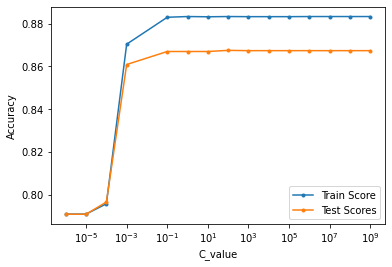

In [55]:
plt.figure()
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, test_scores,label="Test Scores",marker='.')
plt.xscale('log')
plt.xlabel('C_value')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

- As mentioned, the c_value is set to 1.0 by default.
- It appears the 'elbow' C_value is around 0.001, but continues to still train and provide slightly higher accuracy when increased to 1, plateauing there after.
- Will further explore additional hyperparameter optimization by grid searching additional models and parameters below. 

## Grid Searching
The final modeling process seeks to optimize various scalers, dimensionality reduction, and classifiers. This can be achieved by creating and fitting a GridSearchCV model. Below are the different models selected with a brief explanation for choosing each model and their unique qualities for tackling this classification problem.
- Support vector machines (SVMs)
    - maximizes the distance(margin) between the decision boundary and the closest points from the training data.
- K Nearest Neighbors (KNN)
    - Dealing with multi-class data using KNN is simpler. The decision rule for a given point is just the most common class amongst the  𝐾  nearest neighbor.
- Decision Tree 
    - Learns highly non-linear decision boundaries on multi-class data. Unlike KNN, it is not a distance-based classifier constrained to learn using notions of closeness. Instead it works by chaining together simple binary classifiers.


- **NOTE**: The below GridSearchCV model take's about ~10-15 minutes to run.

In [56]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

estimators = [
    ('normalise', StandardScaler()),
    ('dim_reduction', PCA()),
    ('model', svm.SVC())
]


pipe = Pipeline(estimators)

param_grid = [
            {
                'normalise': [StandardScaler(), MinMaxScaler(), RobustScaler()],
                'dim_reduction__n_components': [3, 5, 10],
                'model': [DecisionTreeClassifier()], 
                'model__max_depth': range(1, 10),
            },# number of combinations here: 3 * 3 * 1 * 9 = 81
            {
                'normalise': [StandardScaler(), MinMaxScaler(), RobustScaler()],
                'dim_reduction__n_components': [3, 5, 10],
                'model': [LogisticRegression()], 
                'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            },# number of combinations here: 3 * 3 * 1 * 7 = 63
             {
                'normalise': [StandardScaler(), MinMaxScaler(), RobustScaler()],
                'dim_reduction': [None],
                'model': [KNeighborsClassifier()], 
                'model__n_neighbors': range(1, 40, 2),
            },# number of combinations here: 3 * 1 * 1 * 20 = 60
    
] # total: 204 parameter combinations for pipeline

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1) # this will call fit and score 5 * 204 = 1020 total fits

fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 204 candidates, totalling 1020 fits


In [57]:
fittedgrid.best_estimator_

Pipeline(steps=[('normalise', RobustScaler()),
                ('dim_reduction', PCA(n_components=10)),
                ('model', LogisticRegression(C=0.1))])

In [58]:
# final reported performance of the best estimator
print(f"Best GridSearch score: {fittedgrid.score(X_test, y_test)}")
print(f"Robust Scaler Test score: {logreg_rs_test_acc}")

Best GridSearch score: 0.8655529037390612
Robust Scaler Test score: 0.8703261734287987


- It appears that throwing loads of computer power simply resulted in reinforcing that the LogisticRegression is still the best model. The Robust Scaler version provides slightly better test accuracy with no dimensionality reduction, and a default c-value of 1.
- Final steps will be to evaluate the best model to determine just how informative it really is as well as derive final insights.

### Interpreting Coefficients
The predictor's coefficients help determine their impact on the odds of a driver finishing in the Top 5. This will be visualized by creating a dataframe that charts the exponential of the coefficient by applying the **np.exp()** function, and then sorted by greatest-least with a top 10 filter applied as seen below.
- A noticeable difference in odds are observed when comparing the different scaler models of LogisticRegression to each other, in which ultimately provide confusing results. 
- Another difference noticed was penality of the LR model. By default, penality is 'L2' in sklearn logistic regression model which distorts the value of coefficients (regularization), but if penality='none', the odds ratios slightly increase.

In [59]:
odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, X.columns, columns=['Odds']).sort_values(by='Odds', ascending=False).head(10)

,Odds
completed_laps,5.786894
"(Ferrari,)",1.523839
"(Frazer Nash,)",1.440497
"(cheever,)",1.399061
"(alonso,)",1.388568
"(max_verstappen,)",1.349154
"(piquet,)",1.348638
"(laffite,)",1.343854
"(mario_andretti,)",1.336078
"(Cooper-Castellotti,)",1.332075


- These are the results from the most previous run logreg model, which is believed to be from the grid search. There were several attempts to acquire the best fittedgrid model's coefficient, however it appears there is no such method allowed.
- Interesting take away from these results is a driver who has or shares the most `completed_laps` is over **5.5** times more likely (the odds increase **5.786894** fold) to finish in the Top 5 compared to all other drivers finishing the race with fewer completed laps and yet having all other features the same.

In [60]:
logreg = LogisticRegression() # c-value default is set to 1.0
logreg.fit(X_train, y_train)

odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, X.columns, columns=['Odds']).sort_values(by='Odds', ascending=False).head(10)

,Odds
"(Ferrari,)",2.205739
"(Mercedes,)",1.760220
"(C.German,)",1.732120
"(Red Bull,)",1.702135
"(C.Austrian,)",1.702135
"(Team Lotus,)",1.573593
"(McLaren,)",1.550772
"(Finnish,)",1.499840
"(C.British,)",1.467258
"(Tyrrell,)",1.416925


In [61]:
logreg = LogisticRegression(penalty='none') # c-value default is set to 1.0
logreg.fit(X_train, y_train)

odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, X.columns, columns=['Odds']).sort_values(by='Odds', ascending=False).head(10)

,Odds
"(Ferrari,)",2.652439
"(Mercedes,)",2.077101
"(C.German,)",2.036659
"(C.Austrian,)",1.991395
"(Red Bull,)",1.991395
"(Team Lotus,)",1.800005
"(McLaren,)",1.740691
"(Finnish,)",1.675562
"(C.British,)",1.652135
"(Tyrrell,)",1.571489


- A `Ferrari` or `Mercedes` driver is over **2** times more likely to finish in the Top 5 compared to all other drivers racing for different constructors having all other features the same.
- A driver on a `German` or `Austrian` team is over **1.5** times more likely to finish in the Top 5 compared to all other teams of different nationalities having all other features the same.

In [62]:
logreg = LogisticRegression()
scaler = StandardScaler()
# fit the scaler to the X_train data
scaler = scaler.fit(X_train)
# transform both the X_train and X_test data with the fitted scaler
X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)
# fit model on scaled data
logreg.fit(X_train_ss, y_train)

odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, X.columns, columns=['Odds']).sort_values(by='Odds', ascending=False).head(10)

,Odds
completed_laps,5.758638
"(Ferrari,)",1.356597
"(cheever,)",1.204715
"(laffite,)",1.201535
"(Mercedes,)",1.201042
"(McLaren,)",1.189185
"(piquet,)",1.183886
"(dalmas,)",1.178441
"(alonso,)",1.177972
"(mario_andretti,)",1.174816


- A driver who has or shares the most `completed_laps` is over **5.5** times more likely (the odds increase **5.758638** fold) to finish in the Top 5 compared to all other drivers finishing the race with fewer completed laps and yet having all other features the same.

In [63]:
logreg = LogisticRegression()
scaler = MinMaxScaler()
# fit the scaler to the X_train data
scaler = scaler.fit(X_train)
# transform both the X_train and X_test data with the fitted scaler
X_train_mm = scaler.transform(X_train)
X_test_mm = scaler.transform(X_test)

# fit model on scaled data
logreg.fit(X_train_mm, y_train)

odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, X.columns, columns=['Odds']).sort_values(by='Odds', ascending=False).head(10)

,Odds
completed_laps,20829.708292
"(Penske,)",7.704120
"(Haas F1 Team,)",4.754234
"(cheever,)",4.676752
"(donohue,)",4.556154
"(Ferrari,)",4.026402
"(bonetto,)",3.626970
"(frere,)",3.579948
"(max_verstappen,)",3.487533
"(gurney,)",3.412959


- A driver who has or shares the most `completed_laps` is over **20K** times more likely (the odds increase **20,829.7** fold) to finish in the Top 5 compared to all other drivers finishing the race with fewer completed laps and yet having all other features the same.
- This intense amount of odds is assumed to be related from the effects of the scaler.

In [64]:
logreg = LogisticRegression()
scaler = RobustScaler()
# fit the scaler to the X_train data
scaler = scaler.fit(X_train)
# transform both the X_train and X_test data with the fitted scaler
X_train_rs = scaler.transform(X_train)
X_test_rs = scaler.transform(X_test)

logreg.fit(X_train_rs, y_train)

odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, X.columns, columns=['Odds']).sort_values(by='Odds', ascending=False).head(10)

,Odds
"(Penske,)",11.351096
completed_laps,11.135959
"(Haas F1 Team,)",6.079616
"(cheever,)",5.182119
"(Ferrari,)",3.942895
"(mario_andretti,)",3.820090
"(gurney,)",3.812935
"(donohue,)",3.775713
"(bonetto,)",3.758158
"(emerson_fittipaldi,)",3.528457


- A `Penske` driver is over **11** times more likely (the odds increase **11.351096** fold) to finish on the podium compared to all other drivers racing for different constructors having all other features the same.
- These results are a bit confusing and lead to question the effects from the scalers. For example, Team Penske and Team Haas F1 rarely if ever finished in the top 5, yet they have the highest odds to do so?

### Confusion Matrix
A confusion matrix will be created to examine how the data points were classified for the best logistic regression model seen below. This is observed on the None Scaled LR model where penalty = 'None', with no dimensionality reduction, and default c-value of 1. 
- Note this isn't the model that produced highest test accuracy, however is being chosen based on the observed affects the scalers provide to the other LR model's and their predictor's coefficients/odds.

In [65]:
# Fitting a model
logreg = LogisticRegression(penalty='none') # c-value default is set to 1.0, penalty is default L2
logreg.fit(X_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train, y_train)}")
print(f"Test score: {logreg.score(X_test, y_test)}")

Train score: 0.870042050232981
Test score: 0.8663484486873508


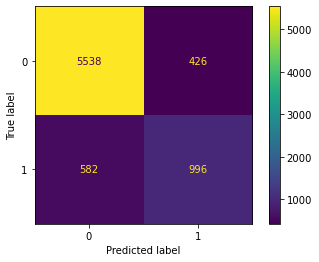

In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# fit model on scaled data
Best_LR_model = LogisticRegression(penalty='none', random_state=42)
Best_LR_model.fit(X_train, y_train)

#visualize the matrix
plot_confusion_matrix(Best_LR_model, X_test, y_test)

- This is a good start but a bit uninterruptible, by making the same confusion matrix by hand there is a bit more information that can provide further insight into the performance of this model.

In [67]:
# Classify the test set
y_pred = Best_LR_model.predict(X_test)

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'])

# Add a column that sums up the actuals
confusion_df['Sum of Actuals'] = confusion_df.sum(axis=1)

# Add a row that sums up the predictions
confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)

# Fix the indices
confusion_df.index=['Actual 0', 'Actual 1', 'Sum of Predictions'] 

# Check
confusion_df

,Predicted 0,Predicted 1,Sum of Actuals
Actual 0,5538,426,5964
Actual 1,582,996,1578
Sum of Predictions,6120,1422,7542


Accuracy, precision and recall can now be manually calculated. This isn't necessary, but it helps in understanding the performance of this model.

#### Accuracy
- Model accuracy is defined as the number of classifications a model correctly predicts divided by the total number of predictions made. It's a way of assessing the performance of a model, but certainly not the only way.

In [71]:
# Accuracy: (TN + TP) / All
(5538+996) / 7542

0.8663484486873508

#### Precision
- Measure of how focused the model is
- Another interpretation: Given a data point that the model has classified as a member of the positive class, what's the probability that this _in fact_ belongs to the positive class?

In [72]:
# Precision: TP / (TP + FP)
996 / 1422

0.70042194092827

#### Recall
- Measure of how well the model "captures" members of the positive class
- Another interpretation: Given a data point belonging to the positive class, what's the probability that the model will classify it as a member of the positive class?

In [73]:
# Recall: TP / (TP + FN)
996 / 1578

0.6311787072243346